# Visualización de datos
MiM+Analytics - Universidad Torcuato Di Tella

### Análisis exploratorio

In [1]:
# Lectura de datos 

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("data/adult.csv")

def get_train_set(data, target_column):
    X_train, _, y_train, _ = train_test_split(data.drop(columns = target_column), data[target_column], test_size=0.33, random_state=42)
    X_train["target"] = y_train
    return X_train

df_train = get_train_set(data, "income")

In [2]:
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
27585,39,Private,160623,Assoc-acdm,12,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
18010,44,Private,92649,HS-grad,9,Married-civ-spouse,Craft-repair,Wife,White,Female,0,0,40,United-States,>50K
22472,52,Private,72743,HS-grad,9,Married-spouse-absent,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States,<=50K
4585,33,Private,118500,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,<=50K
11191,45,Private,189802,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K


### Entrenamiento del modelo

In [3]:
# feature enginnering

def one_hot_encoding(column, column_name):
    df = pd.DataFrame(columns = [f"{column_name}_{col}" for col in column.unique()], index = column.index)
    for col in column.unique():
        df.loc[column == col, f"{column_name}_{col}"] = 1
    return df.fillna(0)

data.workclass.replace("?", "unknow", inplace = True)
data = data.drop(columns = "workclass").join(one_hot_encoding(data.workclass, "workclass"))
data = data.drop(columns = "marital.status").join(one_hot_encoding(data["marital.status"], "marital_status"))
data = data.drop(columns = "relationship").join(one_hot_encoding(data.relationship, "relationship"))
data.occupation.replace("?", "unknow", inplace = True)
data = data.drop(columns = "occupation").join(one_hot_encoding(data.occupation, "ocuppation"))
data = data.drop(columns = "race").join(one_hot_encoding(data.race, "race"))
data = data.drop(columns = "sex").join(one_hot_encoding(data.sex, "sex"))
data["native_usa"] = (data["native.country"] == "United-States").astype(int)
data["target"] = (data["income"] == ">50K").astype(int)
data.drop(columns = ["native.country", "education", "income"], inplace = True)

data.rename(columns = {"education.num":"education", "capital.gain":"capital_gain", "capital.loss":"capital_loss", "hours.per.week":"hours_per_week"}, inplace = True)

# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = "target"), data.target, test_size=0.33, random_state=42)

# Train model

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8574353247720082

### Diagnostico del modelo

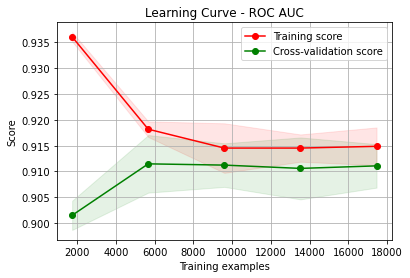

In [21]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.estimators.plot_learning_curve(clf, X_train, y_train, scoring = "roc_auc")
plt.title ("Learning Curve - ROC AUC")
plt.show()

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

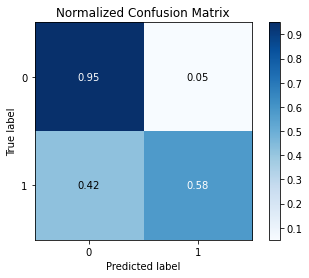

In [22]:
skplt.metrics.plot_confusion_matrix(y_test, clf.predict(X_test), normalize=True)

### Importancia de variables

In [12]:
pd.DataFrame({"importance": clf.feature_importances_}, index = X_train.columns).sort_values(by = "importance", ascending = False).head()

,importance
marital_status_Married-civ-spouse,0.399843
capital_gain,0.195824
marital_status_Married-AF-spouse,0.140693
edication,0.131774
capital_loss,0.045259


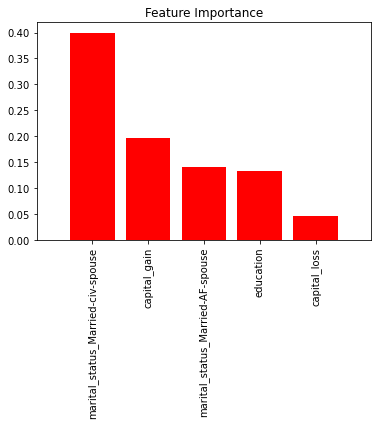

In [16]:
skplt.estimators.plot_feature_importances(clf, feature_names=X_train.columns, max_num_features = 5)
plt.xticks(rotation='vertical')
plt.show()